# LCE

In [1]:
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from lce import LCERegressor

In [2]:
sys.path.insert(0, "../..")
import problem

## Load data

In [3]:
X_train, y_train = problem.get_train_data("../..")
X_test, y_test = problem.get_test_data("../..")

## LCE

In [4]:
date_encoder = FunctionTransformer(problem._encode_dates, kw_args={"drop_date": False})
date_cols = problem._encode_dates(X_train[["date"]]).columns.tolist()

add_date_encoder = FunctionTransformer(
    problem._additional_date_variables, kw_args={"drop_date": True}
)
add_date_cols = ["season"]

num_cols = ["temp", "dwpt", "rhum", "prcp", "wspd", "pres"]

categorical_cols = ["counter_name", "site_name", "wdir"]

preprocessor = ColumnTransformer(
    [
        (
            "date",
            OneHotEncoder(handle_unknown="ignore", sparse=False),
            date_cols + add_date_cols,
        ),
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
    ],
)

regressor = LCERegressor(
    max_features="sqrt",
    max_depth=4,
    max_samples=0.8,
    xgb_n_estimators=(10,),
    xgb_max_depth=(3,),
    xgb_learning_rate=(1,),
    xgb_gamma=(0,),
    xgb_min_child_weight=(1,),
    xgb_reg_lambda=(0,),
    n_jobs=4,
)

pipe = make_pipeline(
    FunctionTransformer(problem._merge_external_data, validate=False),
    date_encoder,
    add_date_encoder,
    preprocessor,
    regressor,
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer-1',
                 FunctionTransformer(func=<function _merge_external_data at 0x7f92683d14c0>)),
                ('functiontransformer-2',
                 FunctionTransformer(func=<function _encode_dates at 0x7f92683d13a0>,
                                     kw_args={'drop_date': False})),
                ('functiontransformer-3',
                 FunctionTransformer(func=<function _additional_date_variables at 0x7f92683d1430>,
                                     kw_args={'dr...
                                                  ['temp', 'dwpt', 'rhum',
                                                   'prcp', 'wspd', 'pres']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['counter_name', 'site_name',
                                                   'wdir'])])),
                ('lceregressor',
                 LCERegressor(max_depth=4, max_features='sqrt', max_samples=0.8,
                              n_jobs=4, xgb_gamma=(0,), xgb_learning_rate=(1,),
                              xgb_max_depth=(3,), xgb_min_child_weight=(1,),
                              xgb_n_estimators=(10,), xgb_reg_lambda=(0,)))])

In [5]:
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

print(f"Train set, RMSE={mean_squared_error(y_train, y_pred_train, squared=False):.2f}")
print(f"Test set, RMSE={mean_squared_error(y_test, y_pred_test, squared=False):.2f}")

Train set, RMSE=0.55
Test set, RMSE=0.52


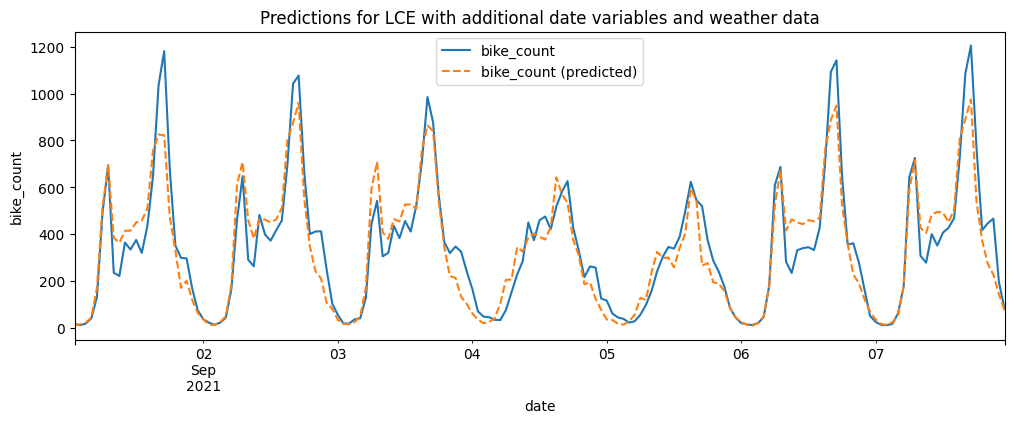

In [6]:
problem.week_plot(
    X_test,
    y_pred_test,
    y_test,
    "LCE with additional date variables and weather data",
)

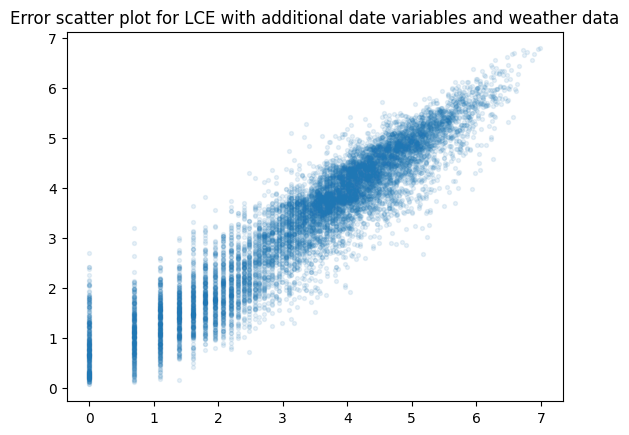

In [7]:
problem.error_plot(
    y_pred_test,
    y_test,
    "LCE with additional date variables and weather data",
)